In [39]:
# import libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split

In [40]:
initialDf = pd.read_csv("steam.csv")
initialDf.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [41]:
for var in initialDf.columns:
    if len(initialDf[var]) != len(initialDf[var].dropna()):
        print(var)
print('Done')
#Check to see if there are any na's

Done


In [42]:
df = pd.DataFrame()
df["Name"] = initialDf["name"].apply(lambda x: str(x))
df["ReleaseYear"] = initialDf["release_date"].apply(lambda x: int(x[0:4]))
df["ReleaseMonth"] = initialDf["release_date"].apply(lambda x: int(x[5:7]))
df["English"] = initialDf["english"].apply(lambda x: int(x))
df["Developer"] = initialDf["developer"].apply(lambda x: str(x))
df["Publisher"] = initialDf["publisher"].apply(lambda x: str(x))
df["Windows"] = initialDf["platforms"].apply(lambda x: bool("windows" in x))
df["Mac"] = initialDf["platforms"].apply(lambda x: bool("mac" in x))
df["Linux"] = initialDf["platforms"].apply(lambda x: bool("linux" in x))
df["RequiredAge"] = initialDf["required_age"].apply(lambda x: int(x))
df["Categories"] = initialDf["categories"].apply(lambda x: str(x))
df["Genre"] = initialDf["genres"].apply(lambda x: str(x))
df["Price"] = initialDf["price"].apply(lambda x: float(x))


df["PositiveRatings"] = initialDf["positive_ratings"].apply(lambda x: int(x))
df["NegativeRatings"] = initialDf["negative_ratings"].apply(lambda x: int(x))
df["MedianPlaytime"] = initialDf["median_playtime"].apply(lambda x: str(x))
df["AveragePlaytime"] = initialDf["average_playtime"].apply(lambda x: str(x))
df["LowerOwners"] = initialDf["owners"].apply(lambda x: int(x[:x.find("-")]))
df["UpperOwners"] = initialDf["owners"].apply(lambda x: int(x[x.find("-")+1:]))

In [43]:
df['Pos_over_Neg'] =  (df['PositiveRatings'] / df['NegativeRatings'] ) * 100

In [44]:
df.head()

,Name,ReleaseYear,ReleaseMonth,English,Developer,Publisher,Windows,Mac,Linux,RequiredAge,Categories,Genre,Price,PositiveRatings,NegativeRatings,MedianPlaytime,AveragePlaytime,LowerOwners,UpperOwners,Pos_over_Neg
0,Counter-Strike,2000,11,1,Valve,Valve,True,True,True,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,7.19,124534,3339,317,17612,10000000,20000000,3729.679545
1,Team Fortress Classic,1999,4,1,Valve,Valve,True,True,True,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,3.99,3318,633,62,277,5000000,10000000,524.170616
2,Day of Defeat,2003,5,1,Valve,Valve,True,True,True,0,Multi-player;Valve Anti-Cheat enabled,Action,3.99,3416,398,34,187,5000000,10000000,858.291457
3,Deathmatch Classic,2001,6,1,Valve,Valve,True,True,True,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,3.99,1273,267,184,258,5000000,10000000,476.779026
4,Half-Life: Opposing Force,1999,11,1,Gearbox Software,Valve,True,True,True,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,3.99,5250,288,415,624,5000000,10000000,1822.916667


In [45]:
df.describe()

,ReleaseYear,ReleaseMonth,English,RequiredAge,Price,PositiveRatings,NegativeRatings,LowerOwners,UpperOwners,Pos_over_Neg
count,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,2.707500e+04,2.707500e+04,2.707500e+04
mean,2016.498098,6.555457,0.981127,0.354903,6.078193,1.000559e+03,211.027147,8.012669e+04,1.880543e+05,inf
std,2.156990,3.459959,0.136081,2.406044,7.874922,1.898872e+04,4284.938531,8.708977e+05,1.786801e+06,NaN
min,1997.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,2.000000e+04,0.000000e+00
25%,2016.000000,3.000000,1.000000,0.000000,1.690000,6.000000e+00,2.000000,0.000000e+00,2.000000e+04,1.400000e+02
50%,2017.000000,7.000000,1.000000,0.000000,3.990000,2.400000e+01,9.000000,0.000000e+00,2.000000e+04,3.172414e+02
75%,2018.000000,10.000000,1.000000,0.000000,7.190000,1.260000e+02,42.000000,2.000000e+04,5.000000e+04,8.425544e+02
max,2019.000000,12.000000,1.000000,18.000000,421.990000,2.644404e+06,487076.000000,1.000000e+08,2.000000e+08,inf


In [46]:
def pos_neg(var):
    y = df['Pos_over_Neg']
    x = df[var]
    figure = plt.figure(figsize = (25,7))
    plt.scatter(x, y, marker='o');
    plt.ylabel('(Positive/Negative) Rating')
    plt.xlabel(var)

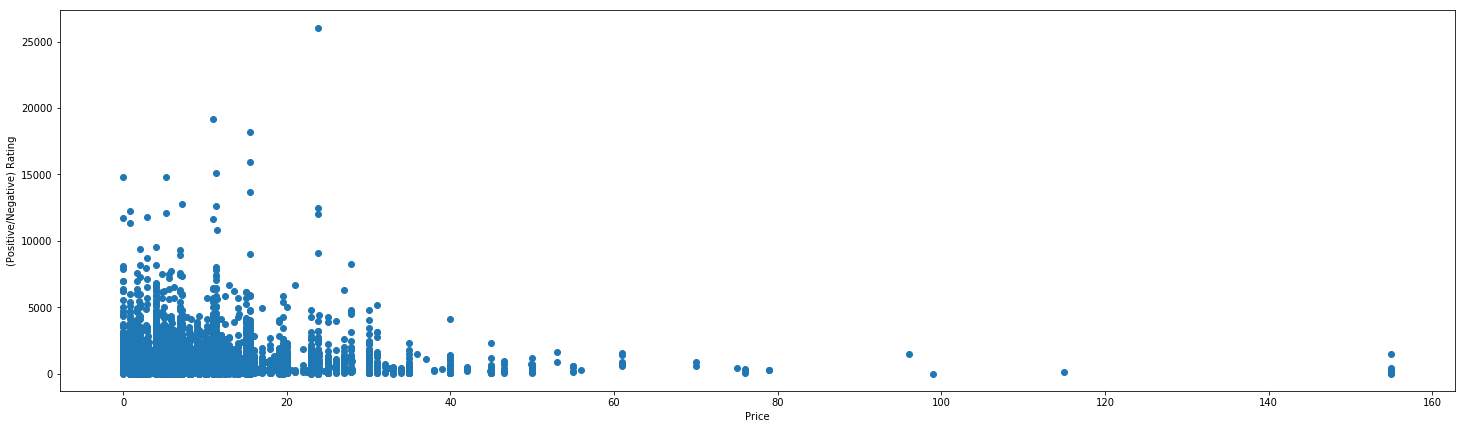

In [47]:
pos_neg("Price")

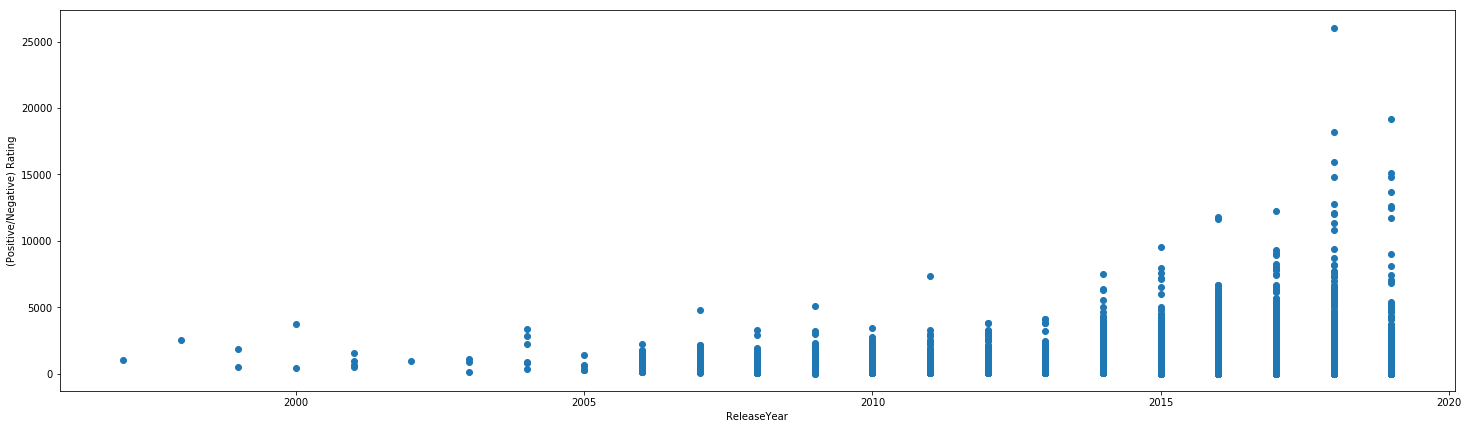

In [48]:
pos_neg("ReleaseYear")

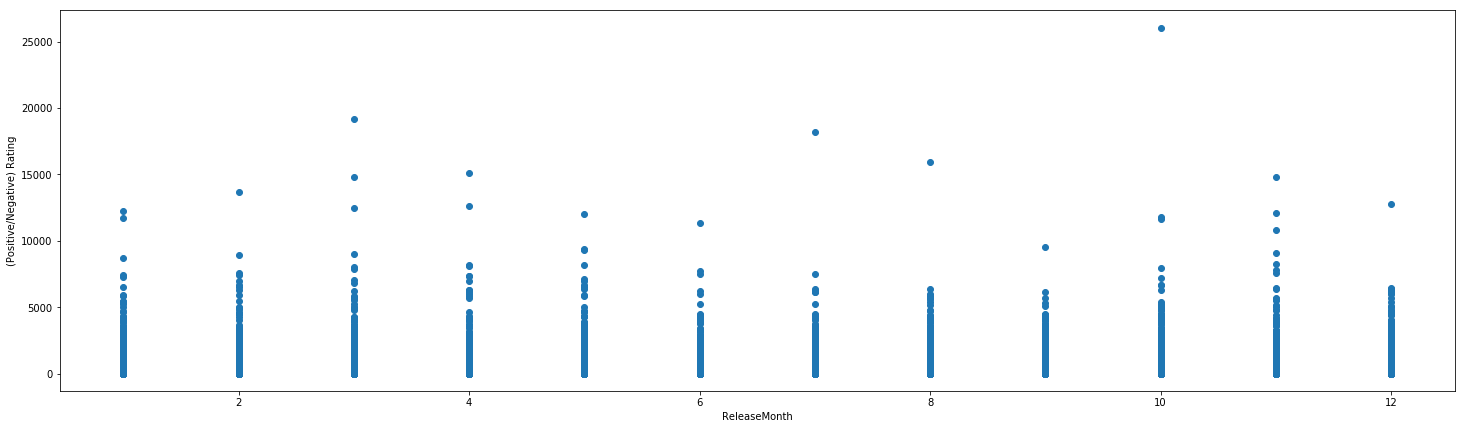

In [49]:
pos_neg("ReleaseMonth")

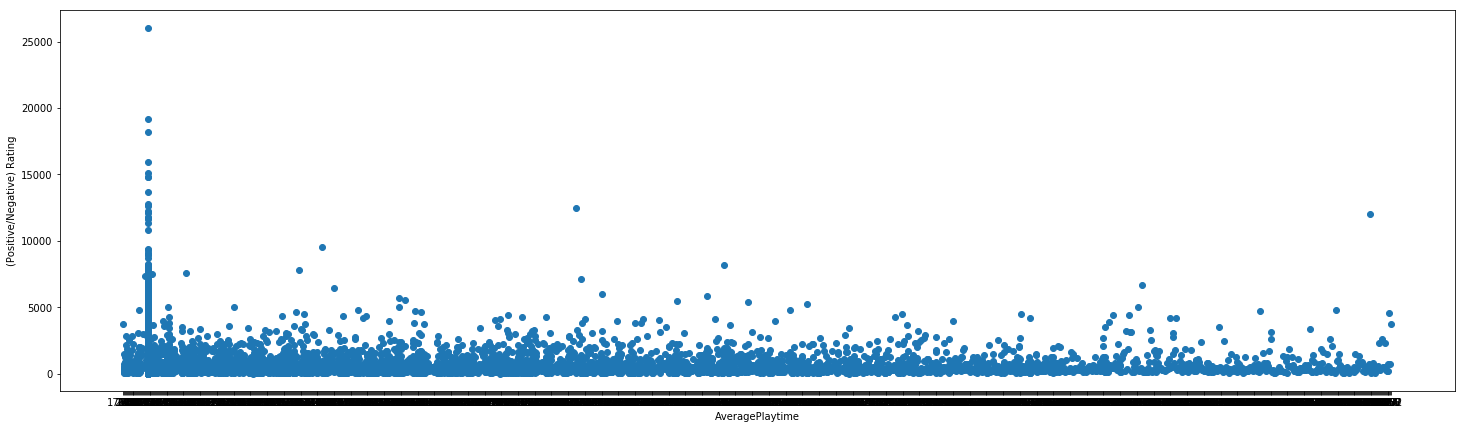

In [50]:
pos_neg("AveragePlaytime")

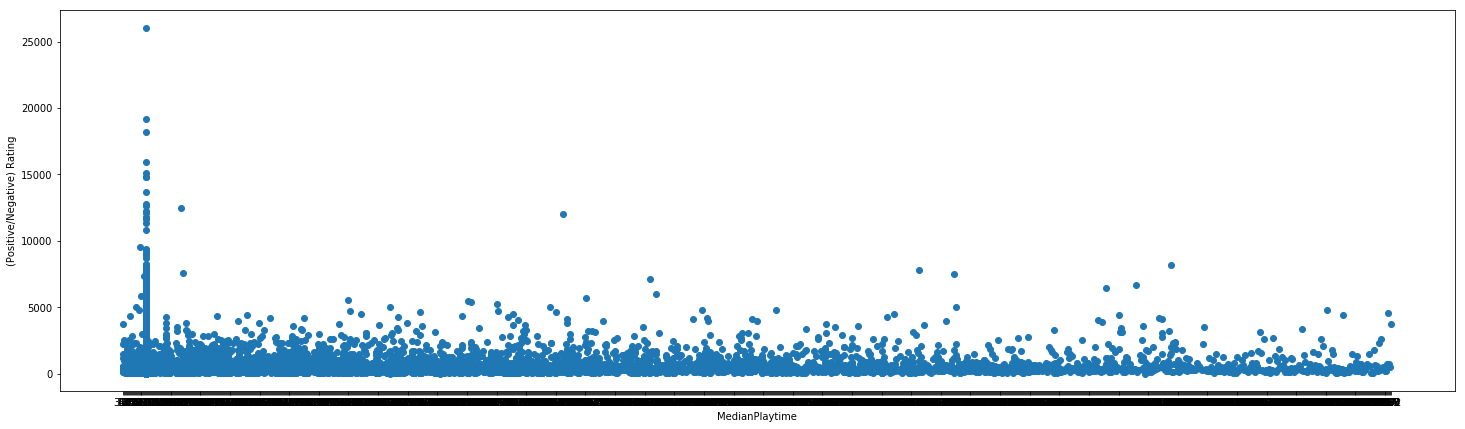

In [51]:
pos_neg("MedianPlaytime")

Text(0, 0.5, '(Positive/Negative) Rating')

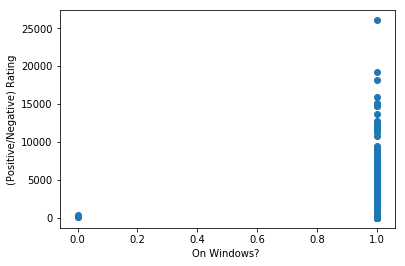

In [52]:
plt.scatter(df.Windows, df["Pos_over_Neg"], label='Widnows')
plt.xlabel('On Windows? ')
plt.ylabel('(Positive/Negative) Rating')

Text(0, 0.5, '(Positive/Negative) Rating')

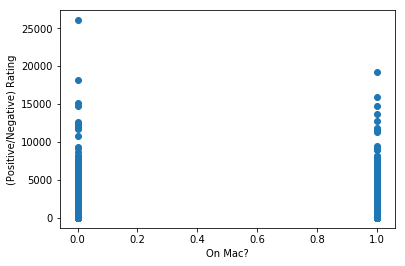

In [53]:
plt.scatter(df.Mac, df["Pos_over_Neg"], label='Mac')
plt.xlabel('On Mac?')
plt.ylabel('(Positive/Negative) Rating')

Text(0, 0.5, '(Positive/Negative) Rating')

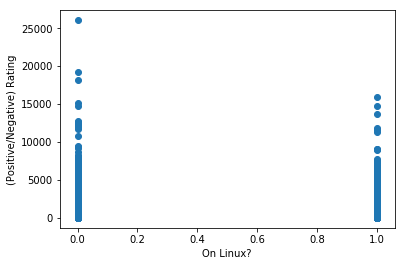

In [54]:
plt.scatter(df.Linux, df["Pos_over_Neg"], label='Linux')
plt.xlabel('On Linux?')
plt.ylabel('(Positive/Negative) Rating')

In [55]:
features = df.columns.drop(["PositiveRatings"])
target = 'PositiveRatings'

In [56]:
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].apply(lambda x: int(1 if x else 0))
print(df)

                                   Name  ReleaseYear  ReleaseMonth  English  \
0                        Counter-Strike         2000            11        1   
1                 Team Fortress Classic         1999             4        1   
2                         Day of Defeat         2003             5        1   
3                    Deathmatch Classic         2001             6        1   
4             Half-Life: Opposing Force         1999            11        1   
5                              Ricochet         2000            11        1   
6                             Half-Life         1998            11        1   
7        Counter-Strike: Condition Zero         2004             3        1   
8                 Half-Life: Blue Shift         2001             6        1   
9                           Half-Life 2         2004            11        1   
10               Counter-Strike: Source         2004            11        1   
11                    Half-Life: Source         2004

In [19]:
lenTrain, lenVal = 25000, 1000
train, test = train_test_split(df, test_size=len(df)-lenTrain-lenVal)
train, val = train_test_split(train, test_size=lenVal)

In [20]:
X_train, X_val, X_test = train[features], val[features], test[features]
y_train, y_val, y_test = train[target], val[target], test[target]

X_train=tf.constant(X_train.values)
X_val=tf.constant(X_val.values)
X_test=tf.constant(X_test.values)

y_train=tf.constant(y_train.values)
y_val=tf.constant(y_val.values)
y_test=tf.constant(y_test.values)

TypeError: Expected binary or unicode string, got 2017

In [21]:
hu1 = 9
hu2 = 4
afunc = tf.nn.relu

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(hu1, activation=afunc))
#model.add(tf.keras.layers.Dense(hu2, activation=afunc))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

AttributeError: module 'tensorflow' has no attribute 'keras'

In [22]:
optim = 'adam'
model.compile(optimizer=optim,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

NameError: name 'model' is not defined

In [23]:
model.fit(X_train, y_train, epochs=50, batch_size=1000)

NameError: name 'model' is not defined

In [24]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(val_loss)
print(val_acc)

NameError: name 'model' is not defined

In [25]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss)
print(val_acc)

NameError: name 'model' is not defined